Frozen({'run': 1, 'time': 6, 'longitude': 360, 'latitude': 181, 'lev': 27})
[20.27453206 42.50551396 32.95643903 32.34503747 34.72501128]
[  0.13       -78.49257752 -52.1174439  -49.66325724 -52.19219493]
[4.96427827 4.38629111 6.74773972 6.93894737 7.38280287]
[ 3.10019718 23.01975358 15.92526294 15.69603743 16.35133922]
[...]
[20.274532 42.505394 32.956505 32.345024 34.725067]
[  0.13     -78.49256  -52.117455 -49.66326  -52.192204]
[4.964278  4.2516985 3.738948  3.957601  4.3264647]
[ 3.1001973 23.133718  18.920916  18.68386   19.352406 ]



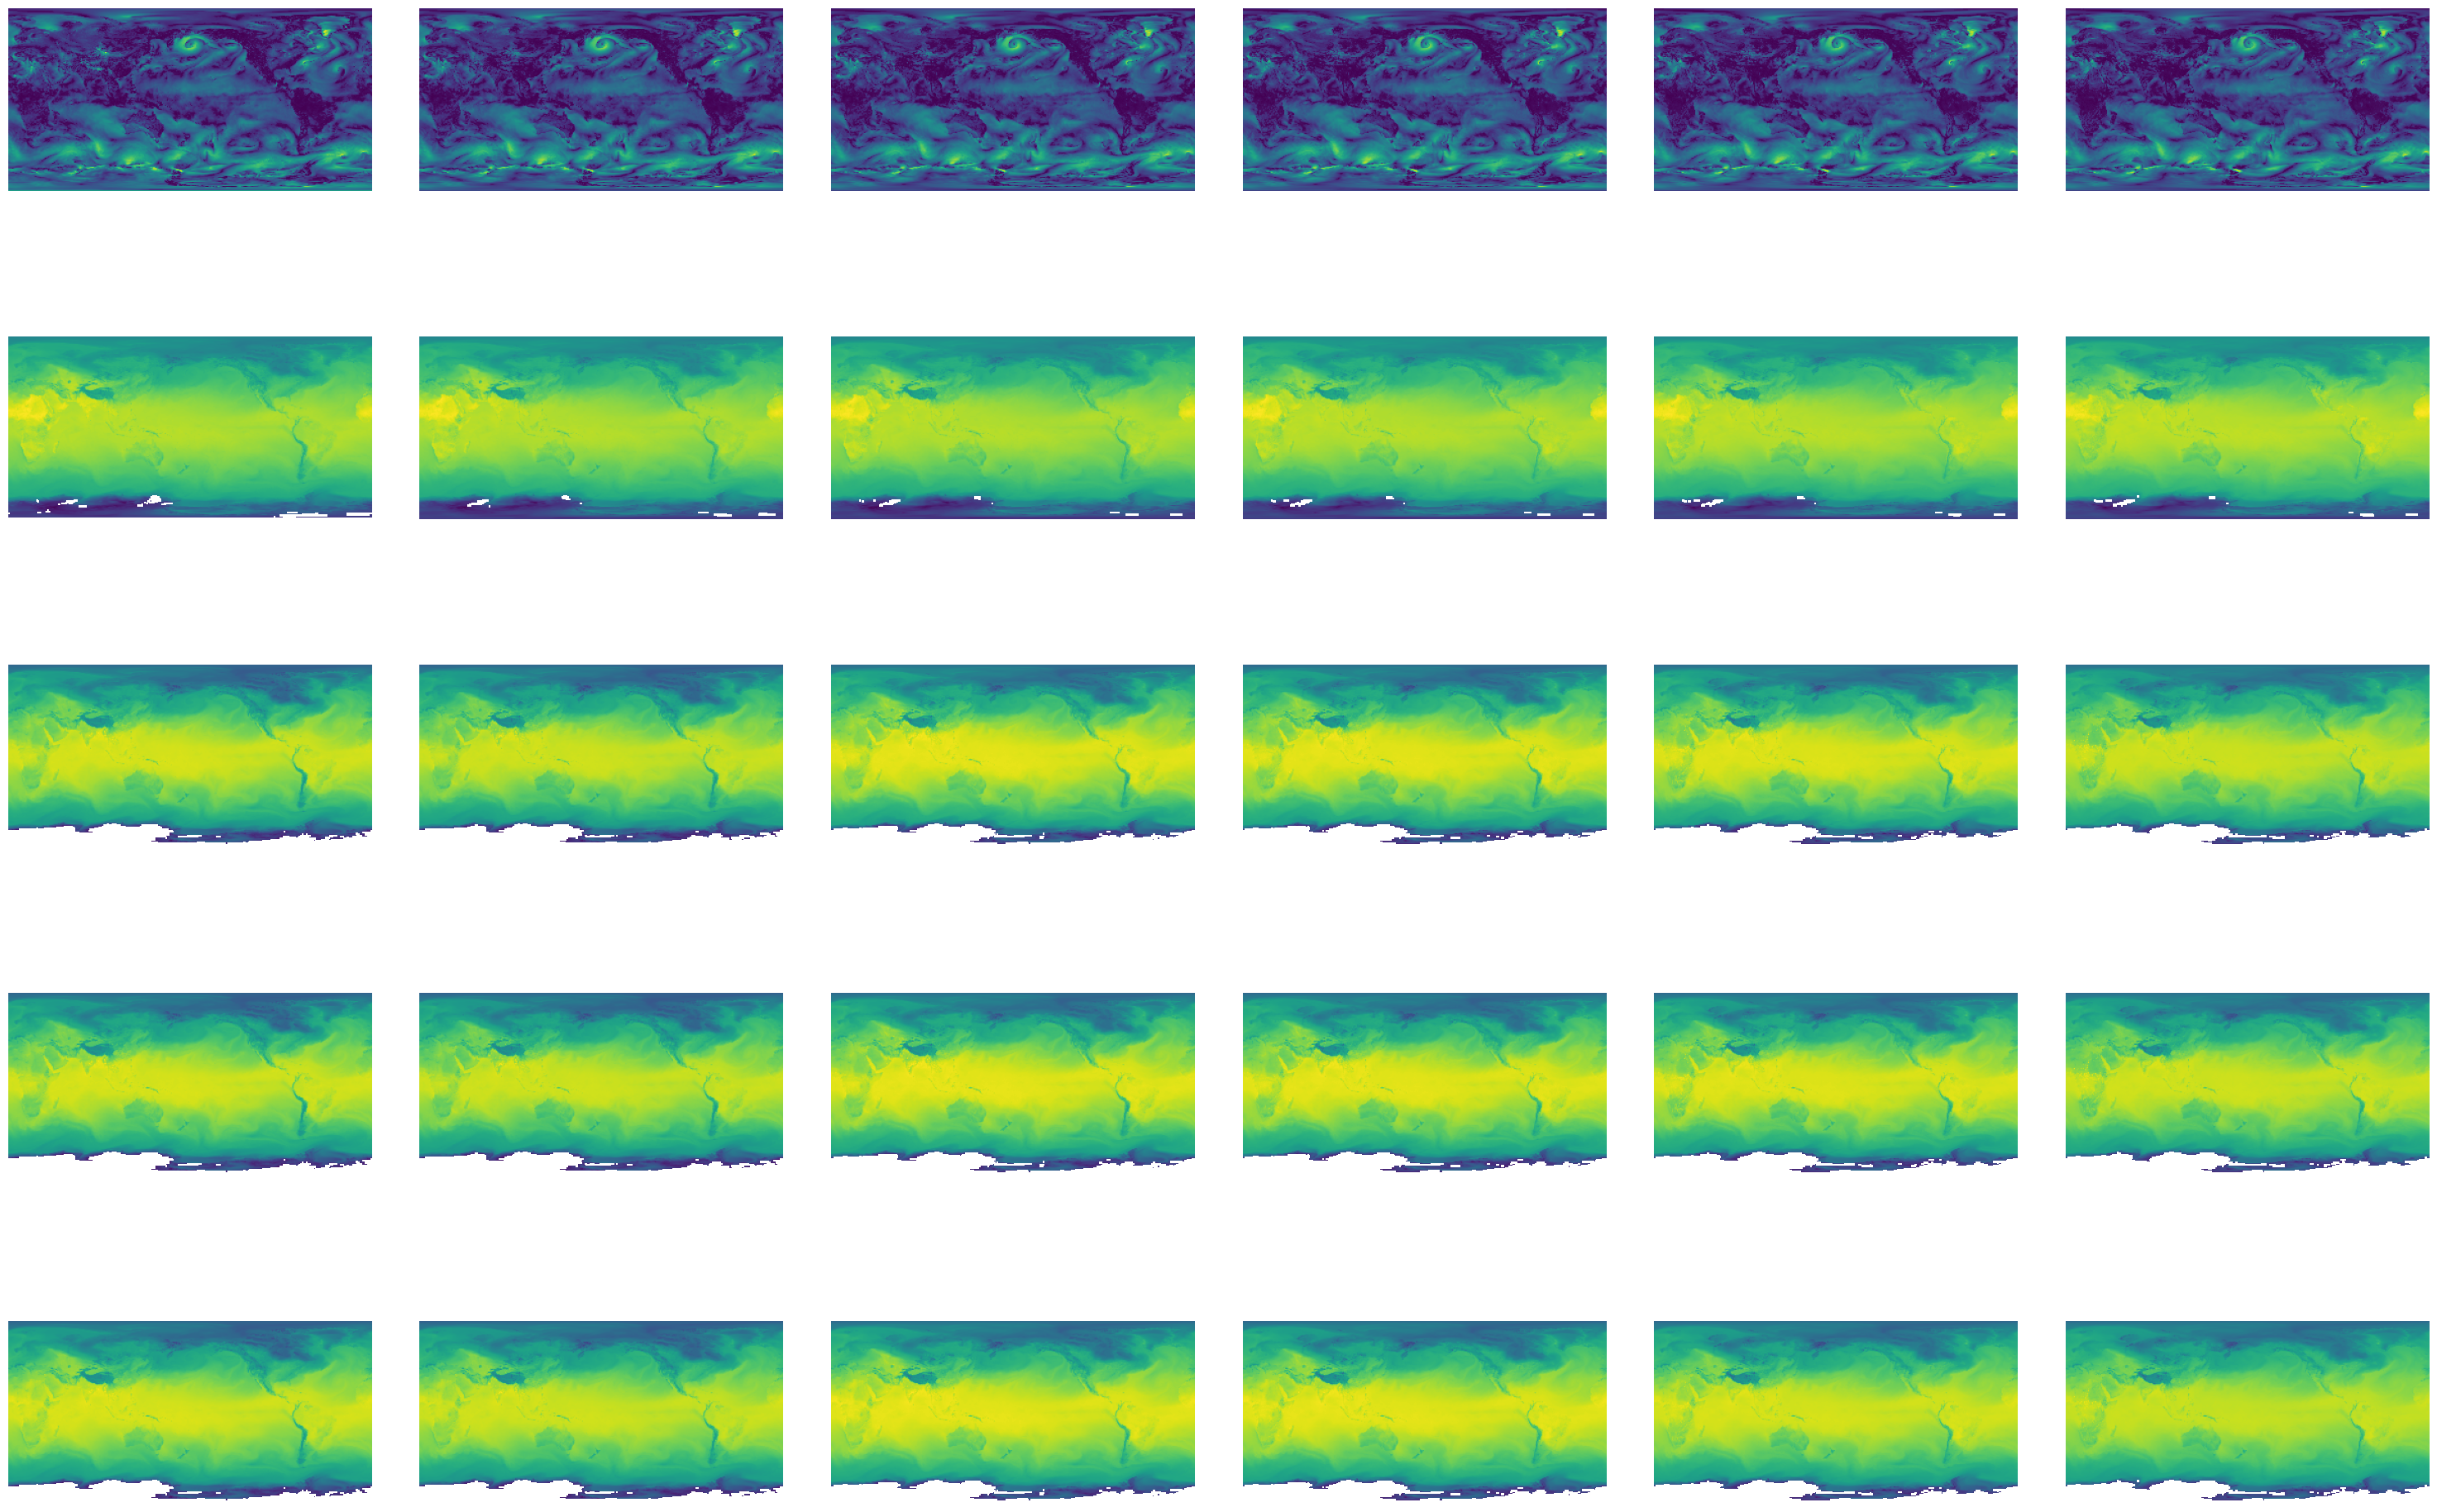

In [1]:
import numpy as np
import xarray as xr
import glob
from nzthermo._c import wbgt
import nzthermo as nzt
import nzthermo.functional as F
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt

T = 144 // 10
Y = 721 // 10
X = 1440 // 10
N = T * Y * X
data = np.random.rand(N).astype(np.float32).reshape(T, Y, X)
out = np.zeros((T, Y, X), dtype=np.float32)
for i in range(N):
    t = i // (Y * X)
    y = (i // X) % Y
    x = i % X

    out[t, y, x] = data[t, y, x]

assert np.all(out == data)




ds = xr.open_mfdataset(glob.glob("../atat/data/**/*.nc", recursive=True))
print(ds.sizes)
# ds = ds.isel(time=slice(0,2), latitude=slice(90,92), longitude=slice(180,182)) 
dt = ds['time'].to_numpy()
lons = (ds['longitude'].to_numpy().astype(np.float64) + 180) % 360 - 180
lats = ds['latitude'].to_numpy().astype(np.float64)

p2 = ds.sel(lev=2)["pressure"].to_numpy().squeeze().astype(np.float64) / 100.0
t2 = ds.sel(lev=2)["temperatureair"].to_numpy().squeeze().astype(np.float64)
u = ds.sel(lev=10)["winducomponent"].to_numpy().squeeze().astype(np.float64)
v = ds.sel(lev=10)["windvcomponent"].to_numpy().squeeze().astype(np.float64)

w10 = np.sqrt(u**2 + v**2)

rh = mpcalc.relative_humidity_from_specific_humidity(
    p2 * units.hPa,
    t2 * units.degK, 
    ds.sel(lev=2)["humidityspecific"].to_numpy().squeeze(), 
).clip(0, 1.2).to("percent").magnitude.astype(np.float64)


plt.rcParams['image.origin'] = 'lower'
data = wbgt(dt, lats, lons, p2, t2, rh, w10, wind_speed_height=10, delta_z=2)
# data =np.nan_to_num(data, nan=np.nanmin(data, axis=(1,2,3)).reshape(-1, 1, 1, 1) )
labels = (
    "est_speed", 'Tg', "Tnwb", "Tpsy", "Twbg"
)
fig, axes = plt.subplots(data.shape[0], data.shape[1], figsize=(30, 20))
fig.tight_layout()
for ax in axes.flatten():
    ax.axis('off')

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        axes[i, j].imshow(data[i, j])
    

data[1:] -= 273.15

print(
    np.nanmax(data , axis=(1,2,3)), 
    np.nanmin(data , axis=(1,2,3)), 
    np.nanmean(data , axis=(1,2,3)),
    np.nanstd(data , axis=(1,2,3)),
"""[...]
[20.274532 42.505394 32.956505 32.345024 34.725067]
[  0.13     -78.49256  -52.117455 -49.66326  -52.192204]
[4.964278  4.2516985 3.738948  3.957601  4.3264647]
[ 3.1001973 23.133718  18.920916  18.68386   19.352406 ]
""",
    sep="\n",
)


In [ ]:
from math import tan, pi as PI
ALB_SFC = 0.2
fdir = 0.1
solar = 1000
sza = 0.3
dl = 0.1
ALB_WICK = 0.2
Fatm = 1.0
num = (1. - ALB_WICK) * solar * ((1. - fdir) * (1. + 0.25 * dl) + fdir * ((tan(sza) / PI) + 0.25 * dl) + ALB_SFC)
print(
    Fatm + (1. - ALB_WICK) * solar * ((1. - fdir) * (1. + 0.25 * dl) + fdir * ((tan(sza) / PI) + 0.25 * dl) + ALB_SFC),
    Fatm + num,
)



In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image



def animate(imgs:np.ndarray):
    fig, ax = plt.subplots()
    fig.tight_layout()
    ax.axis('off')
    im = ax.imshow(imgs[0])

    def update(i):
        im.set_data(imgs[i])
        return im,

    ani = FuncAnimation(fig, update, frames=np.arange(0, data.shape[0]), blit=True)
    
    return ani

animate(data[1]).save("wbgt.gif", writer=animation.ImageMagickFileWriter(fps=10))

display(Image(data=open('wbgt.gif','rb').read(), format='png'));
plt.close()


In [ ]:
animate(data[2]).save("wbgt.gif", writer=animation.ImageMagickFileWriter(fps=10))

display(Image(data=open('wbgt.gif','rb').read(), format='png'))
plt.close()

In [ ]:
animate(data[3]).save("wbgt.gif", writer=animation.ImageMagickFileWriter(fps=10))

display(Image(data=open('wbgt.gif','rb').read(), format='png'))
plt.close()

In [ ]:
animate(data[4]).save("wbgt.gif", writer=animation.ImageMagickFileWriter(fps=10))

display(Image(data=open('wbgt.gif','rb').read(), format='png'))
plt.close()

In [ ]:
T = 144 // 10
Y = 721 // 10
X = 1440 // 10
N = T * Y * X

lons = np.linspace(-180, 180, X)
lats = np.linspace(-90, 90, Y)
lons, lats = np.meshgrid(lons, lats, indexing='xy')

data = np.random.rand(N).astype(np.float32).reshape(T, Y, X)
out = np.zeros((T, Y, X), dtype=np.float32)
for i in range(N):
    t = i // (Y * X)
    y = (i // X) % Y
    x = i % X
    out[t, y, x] = data[t, y, x]
lats.shape

In [ ]:
import numpy as np
import nzthermo as nzt
from nzthermo.const import Rd, Rv, epsilon
from typing import Annotated

import numpy as np

from nzthermo._typing import Pascal, Kelvin, shape, N, Z
import nzthermo.functional as F

np.set_printoptions(precision=2, suppress=True, linewidth=300, threshold=200, edgeitems=200)



def _vaporMixingRatio(e, p):
    return e / (p - e)

_waterSatVaporPressureBolton = nzt.saturation_vapor_pressure
_virtualTemp = nzt.virtual_temperature

def _virtualTemp2(T, qv, p):
    return T * (1. + (qv / epsilon)) / (1. + qv) 

pressure = np.array(
    [1013, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300],
).astype(float)
pressure *= 100.0
temperature = np.array(
    [
        [243, 242, 241, 240, 239, 237, 236, 235, 233, 232, 231, 229, 228, 226, 235, 236, 234, 231, 226, 221, 217, 211],
        [250, 249, 248, 247, 246, 244, 243, 242, 240, 239, 238, 236, 235, 233, 240, 239, 236, 232, 227, 223, 217, 211],
        [293, 292, 290, 288, 287, 285, 284, 282, 281, 279, 279, 280, 279, 278, 275, 270, 268, 264, 260, 254, 246, 237],
        [300, 299, 297, 295, 293, 291, 292, 291, 291, 289, 288, 286, 285, 285, 281, 278, 273, 268, 264, 258, 251, 242],
    ]
).astype(float)
dewpoint = dewPointTemperature = np.array(
    [
        [224, 224, 224, 224, 224, 223, 223, 223, 223, 222, 222, 222, 221, 221, 233, 233, 231, 228, 223, 218, 213, 207],
        [233, 233, 232, 232, 232, 232, 231, 231, 231, 231, 230, 230, 230, 229, 237, 236, 233, 229, 223, 219, 213, 207],
        [288, 288, 287, 286, 281, 280, 279, 277, 276, 275, 270, 258, 244, 247, 243, 254, 262, 248, 229, 232, 229, 224],
        [294, 294, 293, 292, 291, 289, 285, 282, 280, 280, 281, 281, 278, 274, 273, 269, 259, 246, 240, 241, 226, 219],
    ]
).astype(float)


parcelTemperature = nzt.moist_lapse(pressure.reshape(1, -1), temperature[:, 0]) # (N, Z)

#---------------------------------------------------------------------------   
# 4) Find the Equilibrium levels where Buoyancy is zero and compute the
# accumulated buoyant energy at each one of this levels
#---------------------------------------------------------------------------


# First compute B between the surface and the LCL
parcelVaporMixingRatio = _vaporMixingRatio(_waterSatVaporPressureBolton(dewpoint[:, 0]), pressure[:1]) # (N,)
envVirtualTemp = _virtualTemp(temperature, _waterSatVaporPressureBolton(dewPointTemperature)) # (N, Z)
parcelVirtualTemp = _virtualTemp2(parcelTemperature, parcelVaporMixingRatio[:, np.newaxis], pressure) # (N, Z)


buoyancy = Rd * (parcelVirtualTemp  - envVirtualTemp) / pressure # (N, Z)


accumulatedBuoyantEnergy = np.zeros_like(buoyancy)
for level in range(1, len(pressure)):
    accumulatedBuoyantEnergy[:, level] = (
        accumulatedBuoyantEnergy[:, level - 1] 
        - ((pressure[level] - pressure[level - 1]) 
        * 0.5 
        * (buoyancy[:, level] + buoyancy[:, level - 1]))
    )



print(accumulatedBuoyantEnergy)
import metpy.calc as mpcalc
from metpy.units import units

mpcalc.mixed_parcel(
    pressure * units.pascal,
    temperature[0] * units.degK,
    dewpoint[0] * units.degK,
    # parcel_temperature=parcelTemperature * units.degC,
    # parcel_pressure=pressure[0] * units.pascal,
    # parcel_dewpoint=dewpoint[0] * units.degC,
)


In [8]:
from __future__ import annotations
from typing import NamedTuple, Generic, TypeVar, Annotated
import numpy as np
import nzthermo as nzt
from nzthermo._typing import shape, N, Z
float_ = TypeVar("float_", bound=np.float_)
NZIndex = tuple[
        np.ndarray[shape[N], np.dtype[np.intp]],
        np.ndarray[shape[Z], np.dtype[np.intp]],
    ]
class ParcelProfile(NamedTuple, Generic[float_]):
    pressure: np.ndarray[shape[N, Z], np.dtype[float_]]
    temperature: np.ndarray[shape[N, Z], np.dtype[float_]]
    lcl_index: tuple[
        np.ndarray[shape[N], np.dtype[np.intp]],
        np.ndarray[shape[Z], np.dtype[np.intp]],
    ]

    @property
    def lcl_pressure(self) -> np.ndarray[shape[N], np.dtype[float_]]:
        return self.pressure[self.lcl_index]

    @property
    def lcl_temperature(self) -> np.ndarray[shape[N], np.dtype[float_]]:
        return self.temperature[self.lcl_index]
    
    
    def below_lcl(self, copy: bool = True) :
        P, T = self.pressure, self.temperature
        N, Z = self.shape
        if copy:
            P, T = P.copy(), T.copy()
        indices = np.ones(N, dtype=np.int_)[:, None]  * np.arange(Z)
        mask = indices > self.lcl_index[-1][:, None]
        
        P[mask] = np.nan
        T[mask] = np.nan
        return P, T
    
    def above_lcl(self, copy: bool = True) :
        P, T = self.pressure, self.temperature
        N, Z = self.shape
        if copy:
            P, T = P.copy(), T.copy()
        indices = np.ones(N, dtype=np.int_)[:, None]  * np.arange(Z)
        mask = indices < self.lcl_index[-1][:, None]
        
        P[mask] = np.nan
        T[mask] = np.nan
        return P, T
        

    @property
    def shape(self) -> shape[N, Z]:
        return self.pressure.shape # type: ignore

    
def parcel_profile(
    pressure: Annotated[Pascal[np.ndarray[shape[Z], np.dtype[float_]]], "pressure levels"],
    temperature: Annotated[Kelvin[np.ndarray[shape[N], np.dtype[np.float_]]], "surface temperature"],
    dewpoint: Annotated[Kelvin[np.ndarray[shape[N], np.dtype[np.float_]]], "surface dewpoint temperature"],
    sfc_pressure: Annotated[Pascal[np.ndarray[shape[N], np.dtype[np.float_]]], "surface pressure"] | None = None,
) -> ParcelProfile[float_]:
    # add a nan value to the end of the pressure array
    dtype = pressure.dtype
    pressure = np.append(pressure, np.nan)
    N, Z = temperature.shape[0], pressure.shape[0]
    p0 = sfc_pressure or pressure[:1].repeat(N)
    assert temperature.shape == dewpoint.shape == p0.shape == (N,)
    

    indices = np.arange(N)
    
    # - calculate LCL
    lcl_p, lcl_t = nzt.lcl(p0, temperature, dewpoint) # (N,)


    mask = pressure >= lcl_p.reshape(-1, 1) # (N, Z)
    mask[indices, np.argmin(mask, axis=1) + 1] = 0
    
    # [ pressure ]
    P  = np.full((N, Z), np.nan, dtype=dtype)

    nx, zx = np.nonzero(mask)
    P[nx, zx] = pressure[zx]
    
    nx, zx = np.nonzero(~mask & ~np.isnan(pressure))
    P[nx, zx + 1] = pressure[zx]

    # [ temperature ]
    T = np.where(
        mask,
        nzt.dry_lapse(np.where(mask, P, np.nan), temperature[:, np.newaxis], p0[:, np.newaxis]), # lower
        nzt.moist_lapse(np.where(~mask, P, np.nan), temperature, lcl_p) # upper
    )
    lcl_index = np.nonzero(np.isnan(P))
    assert len(lcl_index) == 2 and len(lcl_index[0]) == N == len(lcl_index[1])
    
    P[lcl_index] = lcl_p
    T[lcl_index] = lcl_t

    return ParcelProfile(P, T, lcl_index)





def main():
    pressure = np.array(
        [1013, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300],
    ).astype(float)
    pressure *= 100.0

    temperature = np.array(
        [
            [243, 242, 241, 240, 239, 237, 236, 235, 233, 232, 231, 229, 228, 226, 235, 236, 234, 231, 226, 221, 217, 211],
            [250, 249, 248, 247, 246, 244, 243, 242, 240, 239, 238, 236, 235, 233, 240, 239, 236, 232, 227, 223, 217, 211],
            [293, 292, 290, 288, 287, 285, 284, 282, 281, 279, 279, 280, 279, 278, 275, 270, 268, 264, 260, 254, 246, 237],
            [300, 299, 297, 295, 293, 291, 292, 291, 291, 289, 288, 286, 285, 285, 281, 278, 273, 268, 264, 258, 251, 242],
        ]
    ).astype(float)

    dewpoint = np.array(
        [
            [224, 224, 224, 224, 224, 223, 223, 223, 223, 222, 222, 222, 221, 221, 233, 233, 231, 228, 223, 218, 213, 207],
            [233, 233, 232, 232, 232, 232, 231, 231, 231, 231, 230, 230, 230, 229, 237, 236, 233, 229, 223, 219, 213, 207],
            [288, 288, 287, 286, 281, 280, 279, 277, 276, 275, 270, 258, 244, 247, 243, 254, 262, 248, 229, 232, 229, 224],
            [294, 294, 293, 292, 291, 289, 285, 282, 280, 280, 281, 281, 278, 274, 273, 269, 259, 246, 240, 241, 226, 219],
        ]
    ).astype(float)

    return parcel_profile(pressure, temperature[:, 0], dewpoint[:, 0])

pp = main()
pp

ParcelProfile(pressure=array([[101300.        , 100000.        ,  97500.        ,
         95000.        ,  92500.        ,  90000.        ,
         87500.        ,  85000.        ,  82500.        ,
         80000.        ,  77500.        ,  75000.        ,
         72840.34476965,  72500.        ,  70000.        ,
         65000.        ,  60000.        ,  55000.        ,
         50000.        ,  45000.        ,  40000.        ,
         35000.        ,  30000.        ],
       [101300.        , 100000.        ,  97500.        ,
         95000.        ,  92500.        ,  90000.        ,
         87500.        ,  85000.        ,  82500.        ,
         80000.        ,  77500.        ,  75973.87549461,
         75000.        ,  72500.        ,  70000.        ,
         65000.        ,  60000.        ,  55000.        ,
         50000.        ,  45000.        ,  40000.        ,
         35000.        ,  30000.        ],
       [101300.        , 100000.        ,  97500.        ,
      

In [ ]:
if np.array(1):
    print("yes")
x = np.array(1) 
x or 1

In [ ]:

def _parcel_profile_helper(
    pressure: Annotated[Pascal[np.ndarray[shape, np.dtype]], "pressure levels"],
    temperature: Annotated[Kelvin[np.ndarray[shape, np.dtype]], "surface temperature"],
    dewpoint: Annotated[Kelvin[np.ndarray[shape, np.dtype]], "surface dewpoint temperature"],
) -> tuple[
    Annotated[np.ma.MaskedArray[shape, np.dtype], ...],
    Annotated[np.ndarray[shape, np.dtype], ...],
    Annotated[np.ma.MaskedArray[shape, np.dtype], ...],
    Annotated[np.ma.MaskedArray[shape, np.dtype], ...],
    Annotated[np.ndarray[shape, np.dtype], ...],
    Annotated[np.ma.MaskedArray[shape, np.dtype], ...],
    Annotated[np.ndarray[shape, np.dtype], ...],
]:
    """
    ```python

pressure = np.array(
    [1013, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300],
).astype(float)
pressure *= 100.0
temperature = np.array(
    [
        [243, 242, 241, 240, 239, 237, 236, 235, 233, 232, 231, 229, 228, 226, 235, 236, 234, 231, 226, 221, 217, 211],
        [250, 249, 248, 247, 246, 244, 243, 242, 240, 239, 238, 236, 235, 233, 240, 239, 236, 232, 227, 223, 217, 211],
        [293, 292, 290, 288, 287, 285, 284, 282, 281, 279, 279, 280, 279, 278, 275, 270, 268, 264, 260, 254, 246, 237],
        [300, 299, 297, 295, 293, 291, 292, 291, 291, 289, 288, 286, 285, 285, 281, 278, 273, 268, 264, 258, 251, 242],
    ]
).astype(float)
dewpoint = dewPointTemperature = np.array(
    [
        [224, 224, 224, 224, 224, 223, 223, 223, 223, 222, 222, 222, 221, 221, 233, 233, 231, 228, 223, 218, 213, 207],
        [233, 233, 232, 232, 232, 232, 231, 231, 231, 231, 230, 230, 230, 229, 237, 236, 233, 229, 223, 219, 213, 207],
        [288, 288, 287, 286, 281, 280, 279, 277, 276, 275, 270, 258, 244, 247, 243, 254, 262, 248, 229, 232, 229, 224],
        [294, 294, 293, 292, 291, 289, 285, 282, 280, 280, 281, 281, 278, 274, 273, 269, 259, 246, 240, 241, 226, 219],
    ]
).astype(float)
pph = _parcel_profile_helper(pressure, temperature[:, 0], dewpoint[:, 0])
(masked_array(
   data=[[101300.0, 100000.0, 97500.0, 95000.0, 92500.0, 90000.0, 87500.0, 85000.0, 82500.0, 80000.0, 77500.0, 72840.34476965015, --, --, --, --, --, --, --, --, --, --],
         [101300.0, 100000.0, 97500.0, 95000.0, 92500.0, 90000.0, 87500.0, 85000.0, 82500.0, 80000.0, 75973.87549461005, --, --, --, --, --, --, --, --, --, --, --],
         [101300.0, 100000.0, 97500.0, 94064.316260996, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --],
         [101300.0, 100000.0, 97500.0, 92815.92020833984, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --]],
   mask=[[False, False, False, False, False, False, False, False, False, False, False, False,...], ...],
   fill_value=1e+20),
 array([72840.34, 75973.88, 94064.32, 92815.92]),
 masked_array(
   data=[[--, --, --, --, --, --, --, --, --, --, 72840.34476965015, 75000.0, 72500.0, 70000.0, 65000.0, 60000.0, 55000.0, 50000.0, 45000.0, 40000.0, 35000.0, 30000.0],
         [--, --, --, --, --, --, --, --, --, 75973.87549461005, 77500.0, 75000.0, 72500.0, 70000.0, 65000.0, 60000.0, 55000.0, 50000.0, 45000.0, 40000.0, 35000.0, 30000.0],
         [--, --, 94064.316260996, 95000.0, 92500.0, 90000.0, 87500.0, 85000.0, 82500.0, 80000.0, 77500.0, 75000.0, 72500.0, 70000.0, 65000.0, 60000.0, 55000.0, 50000.0, 45000.0, 40000.0, 35000.0, 30000.0],
         [--, --, 92815.92020833984, 95000.0, 92500.0, 90000.0, 87500.0, 85000.0, 82500.0, 80000.0, 77500.0, 75000.0, 72500.0, 70000.0, 65000.0, 60000.0, 55000.0, 50000.0, 45000.0, 40000.0, 35000.0, 30000.0]],
   mask=[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False, False, False, False, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False, False, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]],
   fill_value=1e+20),
 masked_array(
   data=[[243.0, 242.10489756800098, 240.3599121182907, 238.5826679221013, 236.7716955954258, 234.92541687985656, 233.0421332926621, 231.1200132315985, 229.15707727183644, 227.15118133832698, 225.09999736968595, 221.1471195988639, --, --, --, --, --, --, --, --, --, --],
         [250.0, 249.07911272428086, 247.2838602040028, 245.45541967294375, 243.59227941916234, 241.69281572001702, 239.7552811652902, 237.77779139053345, 235.75830995044902, 233.69463100650924, 230.27213637739553, --, --, --, --, --, --, --, --, --, --, --],
         [293.0, 291.92072011285717, 289.81668415909127, 286.8613492793151, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --],
         [300.0, 298.894935269137, 296.74063224480335, 292.59562934427163, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --]],
   mask=[[False, False, False, False, False, False, False, False, False, False, False, False, True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
            ...
    """
    N = temperature.shape[0]
    p0 = pressure[:1].repeat(N) # (N,)
    indices = np.arange(N)
    
    # - calculate LCL
    lcl_p, lcl_t = nzt.lcl(p0, temperature, dewpoint) # (N,)
    

    mask_lower = pressure >= lcl_p.reshape(-1, 1) # (N, Z)
    mask_lower[indices, np.argmin(mask_lower, axis=1) - 1] = False
    mask_upper = ~mask_lower
    

    p_upper = F.mask_insert(mask_upper, pressure, lcl_p[:, np.newaxis], kind="below", copy=False)  # (N, Z)
    # - lower
    # [[101300. 100000. 97500. 95000. 94171.484 -- ...], ...] (N, Z)
    p_lower = F.mask_insert(mask_lower, pressure, lcl_p[:, np.newaxis], kind="above", copy=False)  # (N, Z)
    t_lower = nzt.dry_lapse(p_lower.data, temperature[:, np.newaxis], p0[:, np.newaxis])

    # - upper
    t_upper = nzt.moist_lapse(
        np.where(mask_upper, p_upper, np.nan), 
        t_lower[indices, np.argmax(mask_upper, axis=1) - 1]
    )

    return (
        p_lower,
        lcl_p, 
        p_upper,
        np.ma.masked_array(t_lower, mask_upper), 
        lcl_t,
        np.ma.masked_array(t_upper, mask_lower),
        mask_upper,
    )
    


def main():
    pressure = np.array(
        [1013, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300],
    ).astype(float)
    pressure *= 100.0
    temperature = np.array(
        [
            [243, 242, 241, 240, 239, 237, 236, 235, 233, 232, 231, 229, 228, 226, 235, 236, 234, 231, 226, 221, 217, 211],
            [250, 249, 248, 247, 246, 244, 243, 242, 240, 239, 238, 236, 235, 233, 240, 239, 236, 232, 227, 223, 217, 211],
            [293, 292, 290, 288, 287, 285, 284, 282, 281, 279, 279, 280, 279, 278, 275, 270, 268, 264, 260, 254, 246, 237],
            [300, 299, 297, 295, 293, 291, 292, 291, 291, 289, 288, 286, 285, 285, 281, 278, 273, 268, 264, 258, 251, 242],
        ]
    ).astype(float)
    dewpoint = dewPointTemperature = np.array(
        [
            [224, 224, 224, 224, 224, 223, 223, 223, 223, 222, 222, 222, 221, 221, 233, 233, 231, 228, 223, 218, 213, 207],
            [233, 233, 232, 232, 232, 232, 231, 231, 231, 231, 230, 230, 230, 229, 237, 236, 233, 229, 223, 219, 213, 207],
            [288, 288, 287, 286, 281, 280, 279, 277, 276, 275, 270, 258, 244, 247, 243, 254, 262, 248, 229, 232, 229, 224],
            [294, 294, 293, 292, 291, 289, 285, 282, 280, 280, 281, 281, 278, 274, 273, 269, 259, 246, 240, 241, 226, 219],
        ]
    ).astype(float)
    N = temperature.shape[0]
    Z = temperature.shape[1]


    return _parcel_profile_helper(pressure, temperature[:, 0], dewpoint[:, 0])

pph = main()

        
        

# p_lower, lcl_p, p_upper, t_lower, lcl_t, t_upper, mask_upper, = pph
# # concat lower and upper
# print(mask_upper)
# mask = p_upper.mask
# print(mask)
# p = p_lower.copy()
# p[~mask] = p_upper[~mask]
# t = t_lower.copy()
# t[~mask] = t_upper[~mask]


# pp = ParcelProfile(p.data, t.data, ~mask)

# # print(
# #     pp.above_lcl()[0],
# #     pp.below_lcl()[0],
# #     sep="\n"
# # )
# pp.pressure



In [ ]:

from typing import NamedTuple, Generic, TypeVar
float_ = TypeVar("float_", bound=np.float_)

class ParcelProfile(NamedTuple, Generic[float_]):
    pressure: np.ndarray[shape[N, Z], np.dtype[float_]]
    temperature: np.ndarray[shape[N, Z], np.dtype[float_]]
    mask: np.ndarray[shape[N, Z], np.dtype[np.bool_]]

    @property
    def indices(self) -> tuple[
        np.ndarray[shape[N], np.dtype[np.uint]],
        np.ndarray[shape[N], np.dtype[np.uint]]
    ]:
        return (
            np.arange(self.pressure.shape[0], dtype=np.uint),
            np.argmax(self.mask, axis=1),
        )

    @property
    def lcl_p(self) -> np.ndarray[shape[N], np.dtype[float_]]:
        return self.pressure[self.indices]

    @property
    def lcl_t(self) -> np.ndarray[shape[N], np.dtype[float_]]:
        return self.temperature[self.indices]
    

    def _get_values(self, mask:np.ndarray, copy:bool = True) -> tuple[
        np.ndarray[shape[N, Z], np.dtype[float_]],
        np.ndarray[shape[N, Z], np.dtype[float_]]
    ]:
        p, t = self.pressure, self.temperature
        if copy is True:
            p, t = p.copy(), t.copy()

        p[mask] = np.nan
        t[mask] = np.nan

        return p, t

    def below_lcl(self, copy:bool = True)-> tuple[
        np.ndarray[shape[N, Z], np.dtype[float_]],
        np.ndarray[shape[N, Z], np.dtype[float_]]
    ]:
        mask = self.mask.copy()
        mask[self.indices] = False
        return self._get_values(mask, copy)
        
    
    
    def above_lcl(self, copy:bool = True)-> tuple[
        np.ndarray[shape[N, Z], np.dtype[float_]],
        np.ndarray[shape[N, Z], np.dtype[float_]]
    ]:
        return self._get_values(~self.mask, copy)
    

p_lower, lcl_p, p_upper, t_lower, lcl_t, t_upper, mask_upper, = pph
# concat lower and upper
print(mask_upper)
mask = p_upper.mask
print(mask)
p = p_lower.copy()
p[~mask] = p_upper[~mask]
t = t_lower.copy()
t[~mask] = t_upper[~mask]


pp = ParcelProfile(p.data, t.data, ~mask)
pp.below_lcl()


In [ ]:
pressure = np.array(
    [1013, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300],
).astype(float)
pressure *= 100.0
temperature = np.array(
    [
        [243, 242, 241, 240, 239, 237, 236, 235, 233, 232, 231, 229, 228, 226, 235, 236, 234, 231, 226, 221, 217, 211],
        [250, 249, 248, 247, 246, 244, 243, 242, 240, 239, 238, 236, 235, 233, 240, 239, 236, 232, 227, 223, 217, 211],
        [293, 292, 290, 288, 287, 285, 284, 282, 281, 279, 279, 280, 279, 278, 275, 270, 268, 264, 260, 254, 246, 237],
        [300, 299, 297, 295, 293, 291, 292, 291, 291, 289, 288, 286, 285, 285, 281, 278, 273, 268, 264, 258, 251, 242],
    ]
).astype(float)
dewpoint = dewPointTemperature = np.array(
    [
        [224, 224, 224, 224, 224, 223, 223, 223, 223, 222, 222, 222, 221, 221, 233, 233, 231, 228, 223, 218, 213, 207],
        [233, 233, 232, 232, 232, 232, 231, 231, 231, 231, 230, 230, 230, 229, 237, 236, 233, 229, 223, 219, 213, 207],
        [288, 288, 287, 286, 281, 280, 279, 277, 276, 275, 270, 258, 244, 247, 243, 254, 262, 248, 229, 232, 229, 224],
        [294, 294, 293, 292, 291, 289, 285, 282, 280, 280, 281, 281, 278, 274, 273, 269, 259, 246, 240, 241, 226, 219],
    ]
).astype(float)


from metpy.calc.thermo import _parcel_profile_helper as _metpy_parcel_profile_helper


metpy_pph = [[x.m for x in _metpy_parcel_profile_helper(pressure * units.pascal, temperature[i, 0] * units.degK, dewpoint[i, 0] * units.degK)] for i in range(4)]
np.set_printoptions(precision=2, suppress=True, linewidth=200)

names = ['p_lower', 'lcl_p', 'p_upper', 't_lower', 'lcl_t', 't_upper']
for i in range(len(metpy_pph)):
    for j in range(6):
        a = metpy_pph[i][j]
        b = pph[j][i]
        if isinstance(b, np.ma.MaskedArray):
            b = b.data[~b.mask]

        print(f"[{names[j]}]", a, b, sep='\n')
